![logo](../../LogoLine_horizon_C3S.png)

# Assessing possible outcomes of seasonal temperature forecast

Production date: 02-05-2024

Produced by: Johannes Langvatn (METNorway)

## 🌍 Use case: Providing seasonal forecast to the public   


## ❓ Quality assessment questions
* **How can I assess the forecast temperatures for two months time?**
* **Do the different forecast systems provide a consistent outlook?**

Seasonal forecast in C3S provides a prediction of the near future. For two months prediction time, emphasis should be put on a probabilistic approach and understanding the uncertainty in the prediction [[1]](https://doi.org/10.1098/rsif.2013.1162). To this end, here we assess important characteristics of seasonal forecasts, how they can be compared, interpreted and used.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* This notebook shows one way to visualise the range of outcomes covered by the ensemble members in seasonal forecast systems from C3S and compare it with the forecast system climatology as a reference.
* The resulting plots show the uncertainty in the forecast (range of outcomes for each forecast system and between forecast systems), how the seasonal forecast differs from the model climatology, and how likely it is that the coming months will be in the lower, middle or upper terciles of the climatology.
* For the specific example provided, forecasts issued in June 2023 and valid for 2m air temperature for a region over Southern Norway in July 2023 shows that:
    * All forecast systems provide a consistent outlook that the month will end up in the upper tercile of the climatology (probabilities between 45 and 61% for the different systems).
    * The climatology of the different forecast systems are quite different, hence they need to be bias adjusted before their face-value  can be combined in a multi-model forecast. This emphasises the need for always comparing the forecasts with the hindcast climatology.
* If the forecast systems yield inconsistent outlooks, a multi system summary (see below) can be employed to determine whether there's a broad consensus with only a few models deviating, or if there's a complete disagreement in forecasted probabilities. In the former scenario, the divergent model systems might be seen as outliers highlighting the possibility of different outcome than the majority. While in the latter, the reliability of the forecast is reduced.
* Seasonal forecasts are inherently probabilistic and must be interpreted considering the chaotic nature of the system and the forecast systems' capabilities and limitations. In general, multi-model system forecasts often provide better estimates of the uncertainty than applying a single system. Due to the long lead times involved and associated uncertainty, forecast skill can only be expected for large-scale features in space and time and using e.g. probabilities for terciles can be useful in decision-making.
```
![tercile_distribution_t2m_without_label.png](94c8182f-0d8a-4b57-bad1-b41d5cf7f1ba.png)

## 📋 Methodology

This code in this notebook enables an assessment of the range of possible outcomes for two months prediction time of seasonal forecast systems, in the case of near surface temperature. For reference, the forecasts are presented together with the expected (normal) range of temperatures for the month and region of interest. The normal range is based on so-called hindcasts of past weather from the same forecasting system.

This quality assessment does not assess the historical quality of the seasonal forecast, as the forecasts (e.g. hindcasts) are not compared with historical outcomes (e.g. observations or re-analyses like ERA5). This will be done in another notebook, and is also done [here](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots), in verification plots for the C3S graphical products.

**[](seasonal_seasonal-monthly-single-levels_uncertainty-quality-flags_q01:section-1)**
   - Choose a selection of forecast systems and versions, forecast start time (year and month), hindcast period (normally 1993-2016), region (latitude-longitude box).
   - Define a weighting function for the gridded data, and if needed conversions for the variables used.

**[](seasonal_seasonal-monthly-single-levels_uncertainty-quality-flags_q01:section-2)**
   - Retrieve data for monthly means of all ensemble members for the selected parameters above, from the data catalogue ”Seasonal forecast monthly statistics on single levels”, for both forecasts and hindcasts
   - Compute the spatial mean of 2 m temperature.

**[](seasonal_seasonal-monthly-single-levels_uncertainty-quality-flags_q01:section-3)**
   - Showing the normal range of each forecast system (hindcast distribution) together with the forecast outcomes. Included in the plots are probabilities of near surface temperature forecast within the lower, middle and upper terciles of the normal range.

**[](seasonal_seasonal-monthly-single-levels_uncertainty-quality-flags_q01:section-4)**
 - The forecast probabilities are combined and visualised at the end in a multi-model plot.


## 📈 Analysis and results

(seasonal_seasonal-monthly-single-levels_uncertainty-quality-flags_q01:section-1)=
### 1. Choose data to use and setup code

In this section, the customisable options of the notebook are set. These variables consists of:

- Model forecast system 
    - forecast centre 
    - system version
- Time
    - forecast year
    - first year of the model hindcast
    - last year of the model hindcast
    - forecast month 
- Region of interest
    - name of the region (only used in figure-captions)
    - latitudes given as slice(maxlat, minlat) in degrees (north is positive values)
    - longitudes given as slice(minlon, maxlon) in degrees (east is positive values)
- Weather parameters
    - name of variable in grib-file
    - name of variable in CADS-api
    - name of the three tercile categories (lower, middle and upper tercile)
- Download parameters
    - chunk size of the data
    - number of concurrent request for parallel download 
- Combination of originating centre and model system (Operational forecast model systems per March 2024):
    - centre = "ecmwf", system = "51"
    - centre = "ukmo", system = "602"
    - centre = "meteo_france", system = "8"
    - centre = "dwd", system = "21"
    - centre = "cmcc", system = "35"
    - centre = "ncep", system = "2"
    - centre = "jma", system = "3"
    - centre = "eccc", system = "2"
    - centre = "eccc", system = "3"

To see the different alternatives see the API-request at the bottom of [this page](https://cds.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=form)

Note: if you want to change parameter you might also want to add conversion functions in this section. For example for precipitation you might want to convert from precipitation rate to total precipitation amount

The data is downloaded to a 1 degree lat/lon grid from 89.5 N to 89.5 S and 179.5 W to 179.5 E which is the grid for the latest model versions of all models except for JMA. The JMA data, which is on a 1.25 x 1.25 grid, is therefore interpolated. This is as a convencience to ensure that the lat-lon slices return the same grids for the different systems, and that we can use similar requests to cds. Otherwise the interpolation would not be needed since we are doing an area average. Also, the 'weights' flag will be set to 'True' in the next section, which means the area average is carried out taking into account the variation of the cell areas with cosine of latitude in the regular lat-lon grid.

In [1]:
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, utils
from dateutil.relativedelta import relativedelta
import os
outdir = "key_figure/"
# Model
models = ["ecmwf:51",
          "ukmo:602",
          "meteo_france:8",
          "dwd:21",
          "cmcc:35",
          "ncep:2",
          "eccc:2",
          "eccc:3",
          "jma:3",
         ]

# Time
year_forecast = 2023
year_start_hindcast = 1993
year_stop_hindcast = 2016
month = 6
leadtime_month = 2

# Region
region_name = "Southern Norway"
lat_slice = slice(64, 58)
lon_slice = slice(4, 14)

# Variable
var_grb = 't2m'
var_api = '2m_temperature'
tercile_name=['COLD','NEAR AVERAGE','WARM']

# Download parameters
chunks = {"year": 1}
n_jobs = 1 

collection_id = "seasonal-monthly-single-levels"

# Construct the request to be sent to CADS
request = {
    "format": "grib",
    "variable": var_api,
    "product_type": "monthly_mean",
    "leadtime_month": leadtime_month,
    "area": [89.5, -179.5, -89.5, 179.5],
    "grid": "1/1",
    "month": f"{month:02d}",
}

# Define the weighting function
def regionalised_mean(ds, lon_slice, lat_slice, weights):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    ds = diagnostics.spatial_weighted_mean(ds, weights=weights)
    # Convert from K to C if variable is 2m air temperature
    if "p167" in ds:
        ds = ds.rename(p167="t2m")
    if(var_grb=='t2m'): 
       with xr.set_options(keep_attrs=True):
           ds[var_grb] -= 273.15
       ds[var_grb].attrs["units"] = "°C"
    return ds

(seasonal_seasonal-monthly-single-levels_uncertainty-quality-flags_q01:section-2)=
### 2. Seasonal forecast and hindcast data retrieval and area average
In this section the seasonal data are downloaded and transformed into regionalised means. The time is transformed into two variables ‘time/indexing_time’ and ‘forecast month’. For burst ensemble models ‘time’ is the time when all ensembles are initialised. For lagged ensemble models (JMA, NCEP and UK MetOffice) the ‘indexing_time’ must be used instead of ‘time’ in order to get the same variable, since ensemble members have different initialisation time (See more on this [confluence-page](https://confluence.ecmwf.int/display/CKB/Seasonal+forecasts+and+the+Copernicus+Climate+Change+Service#SeasonalforecastsandtheCopernicusClimateChangeService-%22Burst%22vs.%22lagged%22mode)).  The ‘forecast month’ is the lead time month from month 1 to 6.  

In [2]:
all_datasets = {}
for string in models:
    centre, system = string.split(":")
    all_datasets[centre+system] = {"hindcast": None, "forecast": None}
    request["system"] = system
    request["originating_centre"] = centre
    for model_type, years in {
        "hindcast": range(year_start_hindcast, year_stop_hindcast + 1),
        "forecast": [year_forecast],
    }.items():
        ds = download.download_and_transform(
            collection_id,
            request | {"year": list(map(str, years))},
            chunks=chunks,
            n_jobs=n_jobs,
            transform_func=regionalised_mean,
            transform_func_kwargs={
                "lon_slice": lon_slice,
                "lat_slice": lat_slice,
                "weights": True,
            },
            backend_kwargs={
                "time_dims": (
                    "forecastMonth",
                    "indexing_time" if centre in ["ukmo", "jma", "ncep"] else "time",
                )
            },
            cached_open_mfdataset_kwargs={
                "combine": "nested",
                "concat_dim": "forecast_reference_time",
            },
        )
        # Store the downloaded dataset in the dictionary
        all_datasets[centre+system][model_type] = ds

100%|██████████| 1/1 [00:00<00:00, 46.99it/s]


(seasonal_seasonal-monthly-single-levels_uncertainty-quality-flags_q01:section-3)=
### 3. Make histogram plots for each forecast system
This section extracts data for the selected region from the monthly data on single levels and compute the spatial mean of the chosen variable. Then density plots are created for each lead time month. The resulting plots show the uncertainty in the forecast (range of outcomes), how the seasonal forecast differs from the model climatology, and how likely it is that the coming months will be in the lower, middle or upper terciles of the climatology.

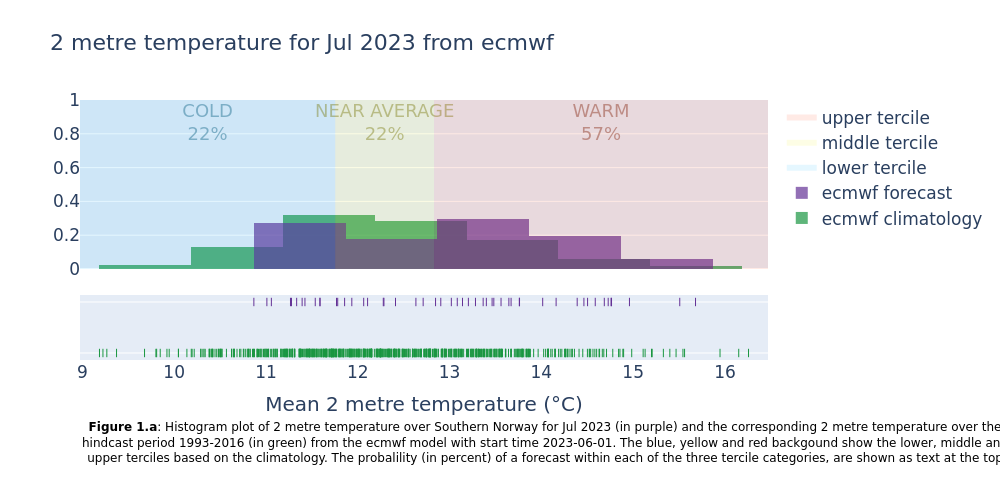

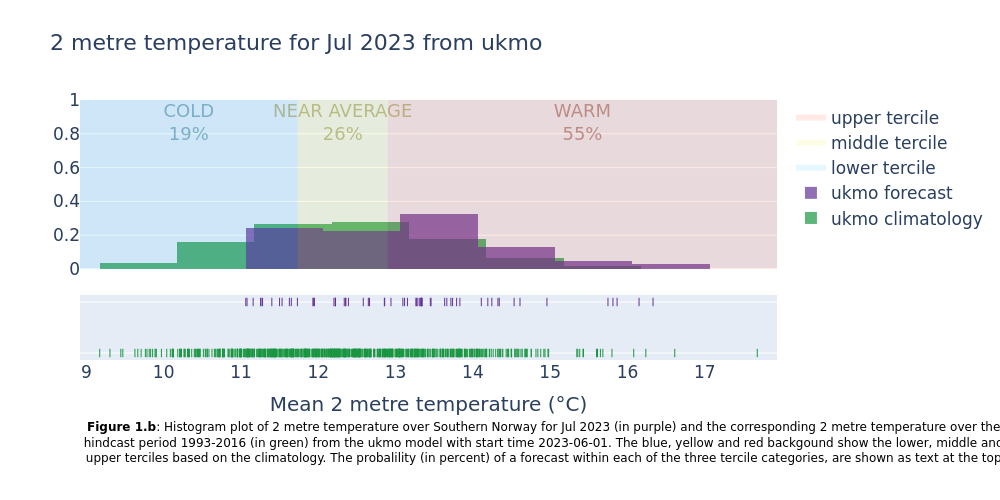

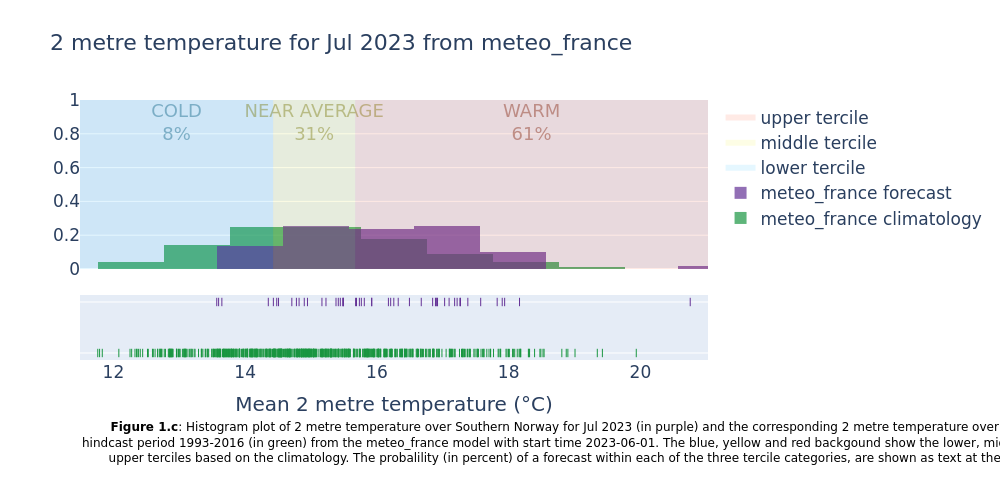

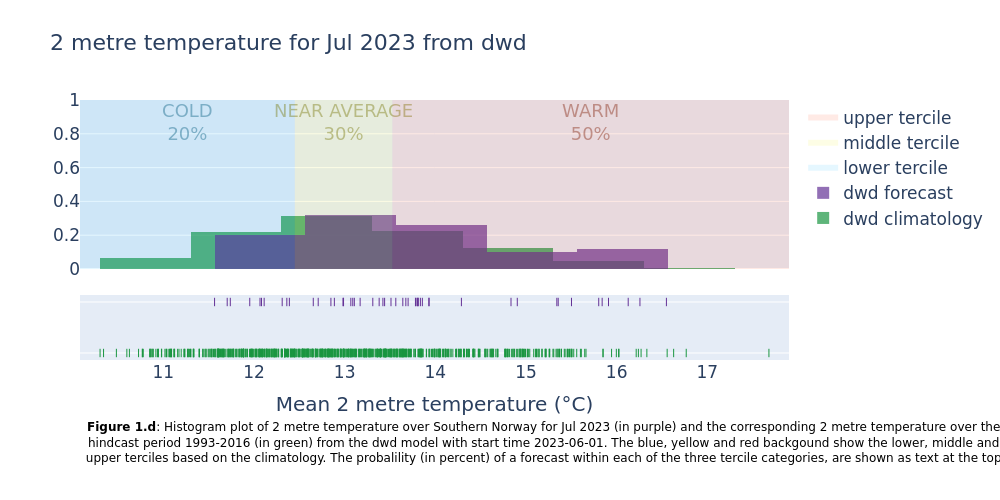

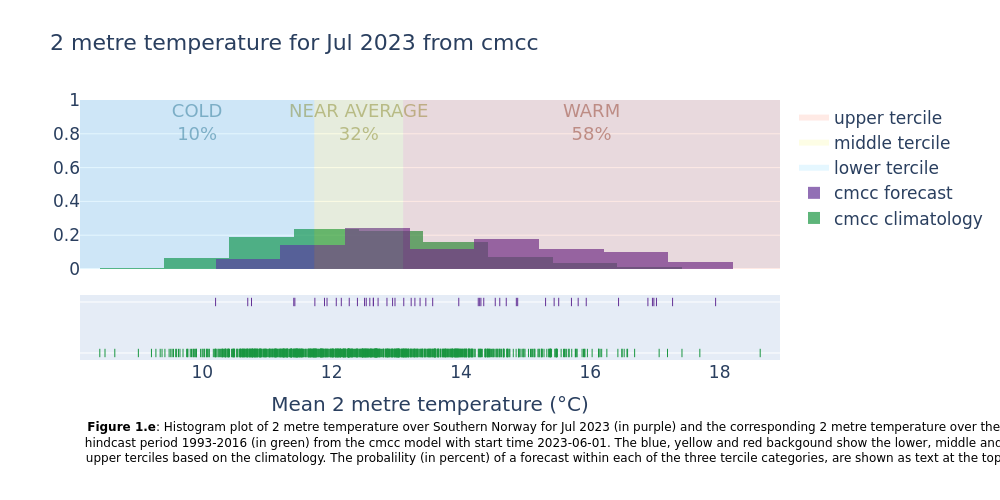

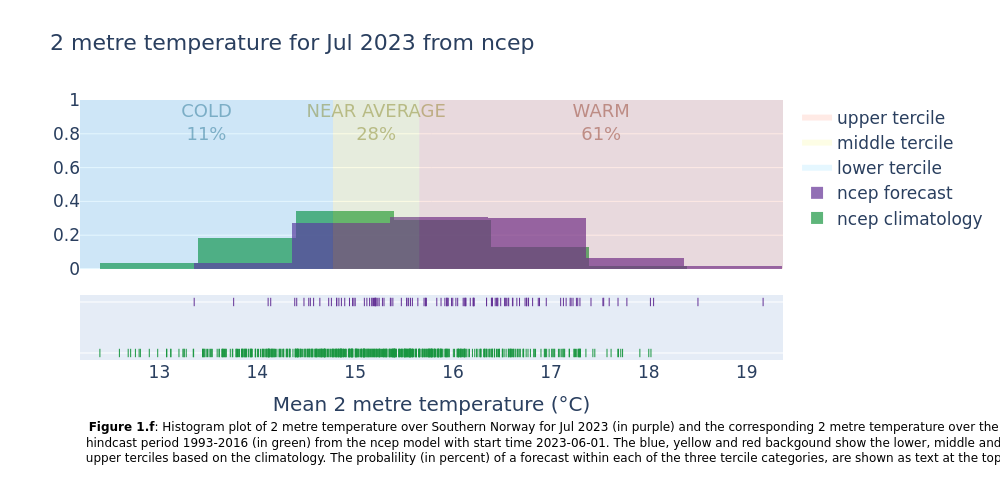

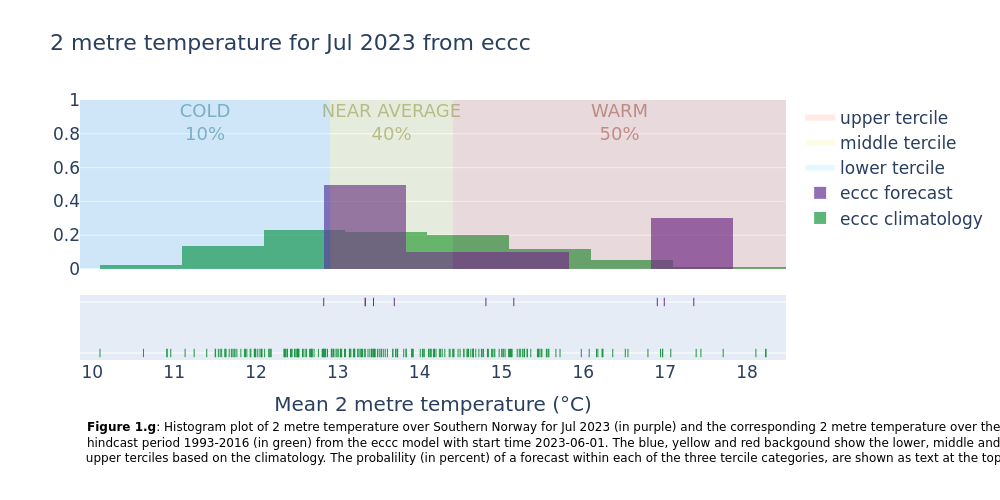

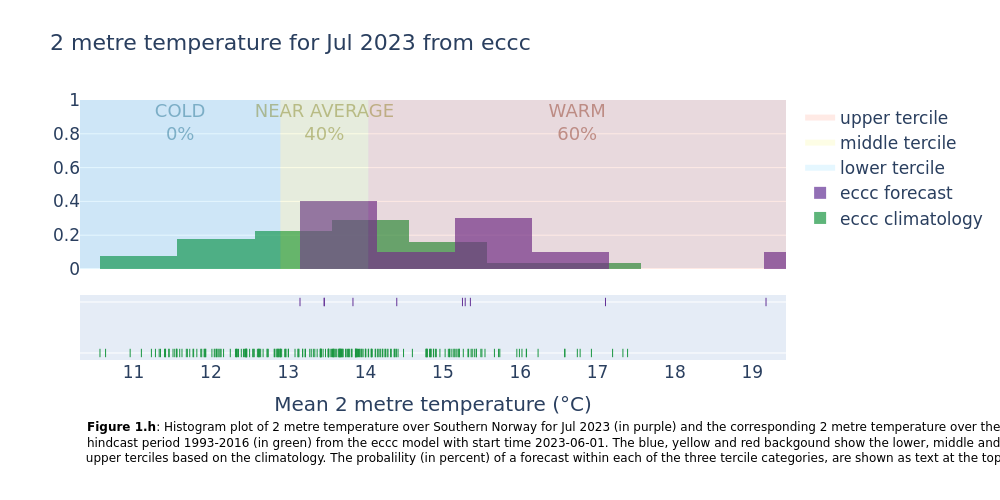

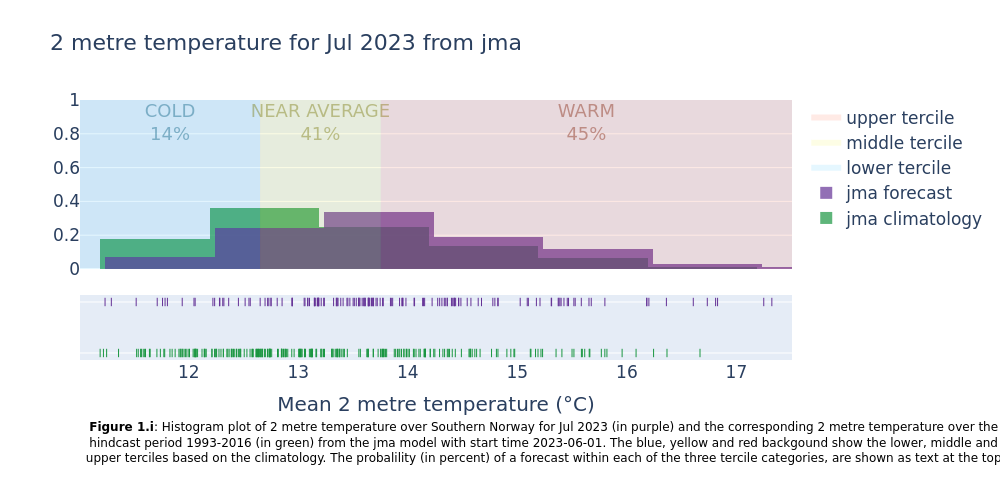

In [3]:
def get_limits_histogram(data, xfactor, yfactor):
    ylim = [0, 1]
    xlim = [min([d.xbins["start"] for d in data]), max([d.xbins["end"] for d in data])]
    xshift = abs(xlim[1] - xlim[0]) * xfactor
    xlim = [x + xshift * sign for x, sign in zip(xlim, (-1, 1))]
    return xlim, ylim

# Set up for for multi-ensemble histogram plot
ensemble_data = {"lower tercile": [], "middle tercile": [] , "upper tercile": []}
multi_ensemble = {"model" : [], "data": ensemble_data}
letters = ["a","b","c","d","e","f","g","h","i","j","k","l","m"]

# Histogram plot for each model system
for number, string in enumerate(models):
    centre, system = string.split(":")
    datasets = all_datasets[centre+system] 
    ds_forecast =  datasets["forecast"]
    ds_hindcast = datasets["hindcast"]
    
    colors = [(26, 150, 65), (100, 50, 150)]
    values = [
        ds_hindcast[var_grb].values.flatten(),
        ds_forecast[var_grb].values.flatten(),
    ]

    labels = [centre + " climatology", centre + " forecast"]

    fig = ff.create_distplot(
        values,
        labels,
        show_hist=True,
        show_curve=False,
        colors=[f"rgb{color}" for color in colors],
    )
    xlim, ylim = get_limits_histogram(fig.data[:2], xfactor=0.03, yfactor=1)

    quantiles = np.quantile(values[0], [1 / 3, 2 / 3]).tolist()
    scatter_dicts = {
        "lower tercile": {
            "color": (0, 180, 250, 0.1),
            "text": tercile_name[0],
            "mask": values[1] <= quantiles[0],
            "xlim": [xlim[0], quantiles[0]],
        },
        "middle tercile": {
            "color": (230, 230, 0, 0.1),
            "text": tercile_name[1],
            "mask": (values[1] > quantiles[0]) & (values[1] <= quantiles[1]),
            "xlim": quantiles,
        },
        "upper tercile": {
            "color": (250, 50, 0, 0.1),
            "text": tercile_name[2],
            "mask": values[1] > quantiles[1],
            "xlim": [quantiles[1], xlim[1]],
        },
    }
    for i, (name, scatter_dict) in enumerate(scatter_dicts.items()):
        # Add background color and text
        fig.add_scatter(
            x=scatter_dict["xlim"],
            y=[ylim[1]] * 2,
            fill="tozeroy",
            mode="none",
            fillcolor=f"rgba{scatter_dict['color']}",
            name=name,
        )
        percentage = 100 * scatter_dict["mask"].sum() / values[1].size
        text_color = tuple(c // 2 for c in scatter_dict["color"][:-1]) + (0.4,)
        fig.add_scatter(
            x=[sum(scatter_dict["xlim"]) / 2],
            y=[ylim[1] * 0.98],
            mode="text",
            name="",
            text=f"{scatter_dict['text']}<br>{round(percentage)}%",
            textfont=dict(size=18, color=f"rgba{text_color}"),
            textposition="bottom center",
            showlegend=False,
        )
        ensemble_data[name].append(percentage)
    multi_ensemble["model"].append(centre+"-"+system)

    # Text and labels
    (forecast_reference_time,) = ds_forecast["forecast_reference_time"].dt.date.values
    valid_time = forecast_reference_time + relativedelta(months=leadtime_month - 1)
    title = f"{ds_forecast[var_grb].attrs['long_name']} for {valid_time.strftime('%b %Y')} from {centre}"
    letter = letters[number]
    # Text below each plot
    annotation = {
       'xref': 'paper',
       'yref': 'paper',  
       'x': -0.00,  
       'y': -0.45,  
       'showarrow': False,
       'yshift':10,
       'font': {'size': 12, 'color': 'black'},
       'text': (
                f"<b>Figure 1.{letter}</b>: Histogram plot of {ds_forecast[var_grb].attrs['long_name']} over {region_name} for {valid_time.strftime('%b %Y')} (in purple) "
                f"and the corresponding {ds_forecast[var_grb].attrs['long_name']} over the <br>hindcast period {year_start_hindcast}-"
                f"{year_stop_hindcast} (in green) from the {centre} model with start time {forecast_reference_time}. The blue, yellow and red backgound show the lower, middle " 
                f"and <br> upper terciles based on the climatology. The probalility (in percent) of a forecast within each of the "
                f"three tercile categories, are shown as text at the top. "
       )
    } 
    fig.update_layout(
        title=dict(text=title, font={"size": 22}),
        yaxis_range=ylim,
        xaxis_range=xlim,
        font_size=17,
        autosize=False,
        width=1000,
        height=500,
        margin = dict(b = 140), 
        annotations=[annotation]
    )
    fig.update_xaxes(
        title_text=(
            f"Mean {ds_forecast[var_grb].attrs['long_name']}"
            f" ({ds_forecast[var_grb].attrs['units']})"
        )
    )
    fig.show(renderer="png")

(seasonal_seasonal-monthly-single-levels_uncertainty-quality-flags_q01:section-4)=
### 4. Summarise the probabilities for each system
This section summarises the forecasted probabilites of the temperature being colder, near average or warmer than their respective hindcast climatologies for all systems.
The figure produced reinforces the findings from the figures produced in the last section, that it is more likely to be warmer than usual, compared to the model hindcast climatology than it is to be average or colder compared to the hindcast.

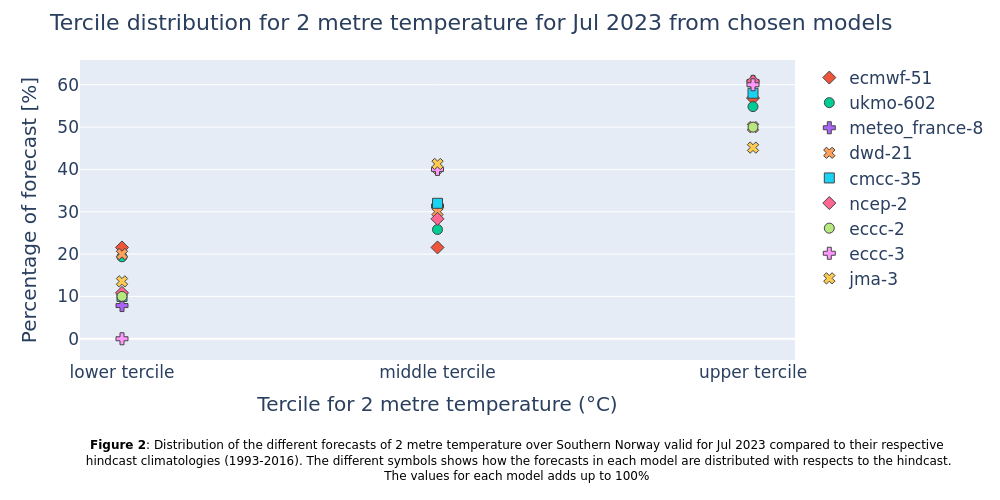

In [4]:
# Plotting the multi-ensemble histogram
title = f"Tercile distribution for {ds_forecast[var_grb].attrs['long_name']} for {valid_time.strftime('%b %Y')} from chosen models"
symbols = ["diamond", "circle", "cross", "x", "square"]
fig = px.box()

for model_index, model in enumerate(multi_ensemble["model"]):
    values = []
    x_index = []
    for name, tercile in multi_ensemble["data"].items():
        x_index.append(name)
        values.append(tercile[model_index])
    fig.add_scatter(x=x_index, y = values, mode = "markers", name = model, marker_size=10, 
                    marker_symbol = symbols[model_index%len(symbols)], 
                    marker_line_width=1,
                   )

annotation = {
   'xref': 'paper',
   'yref': 'paper',  
   'x': -0.00,  
   'y': -0.45,  
   'showarrow': False,
   'yshift':10,
   'font': {'size': 12, 'color': 'black'},
   'text': (
            f"<b>Figure 2</b>: Distribution of the different forecasts of {ds_forecast[var_grb].attrs['long_name']} over {region_name} valid for {valid_time.strftime('%b %Y')} "
            f"compared to their respective <br> hindcast climatologies ({year_start_hindcast}-{year_stop_hindcast}). " 
            f"The different symbols shows how the forecasts in each model are distributed with respects to the hindcast. <br>"
            f"The values for each model adds up to 100% "
   )
}
fig.update_layout(
    title=dict(text=title, font={"size":22}),
    font_size=17,
    width=1000,
    height=500,
    margin = dict(b = 140),
    annotations=[annotation]

)
fig.update_yaxes(
    title_text="Percentage of forecast [%]"
)
fig.update_xaxes(
    title_text=(
        f" Tercile for {ds_forecast[var_grb].attrs['long_name']}"
        f" ({ds_forecast[var_grb].attrs['units']})"
    )
)
fig.show(renderer="png")
fig.write_image(outdir + "tercile_distribution_t2m.png")

Figure 1 shows the uncertainty, the range of outcomes covered by the ensemble members in the different seasonal forecast systems separately, while Figure 2 shows the probabilities from all the individual forecast systems for the lower, middle, and upper tercile together. While all systems show the same tendency towards that the upper tercile has the highest probability, there is still a substantial chance for the lower and middle tercile to happen as well. In fact, the probability of not ending up in the upper tercile is still around 50%.  

To answer to the questions stated initially; The generated plots assess the forecasted temperatures with a two months lead time and indicate that the most likely tercile is the upper tercile, but that it is almost equally likely that we will not end up in the upper tercile. In particular, Figure 2 shows that the different seasonal forecast systems provide a consistent outlook. In general, multi-model system forecasts often provide better forecasts and estimates of the uncertainty than applying a single model system (e.g. Doblas-Reyes et al., 2009 \[[2](https://doi.org/10.1002/qj.464)\]).

There are multiple ways to visualize seasonal forecasts and their associated uncertainty as probabilistic forecasts. C3S provides more examples of this as  in the graphical products: https://climate.copernicus.eu/charts/packages/c3s_seasonal/

## ℹ️ If you want to know more

### Key resources
 - Seasonal forecast single level anomalies: DOI: [10.24381/cds.7e37c951](https://doi.org/10.24381/cds.7e37c951)
 - Seasonal forecast monthly statistics single level: DOI: [10.24381/cds.68dd14c3](https://doi.org/10.24381/cds.68dd14c3)

### Code libraries used
 - xarray
 - numpy
 - express and figure_factory from plotly
 - [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

### References
[[1]](https://doi.org/10.1098/rsif.2013.1162) - Weisheimer A. and Palmer T. N.. 2014 On the reliability of seasonal climate forecasts *J. R. Soc.* Interface. **11:** 20131162.
https://doi.org/10.1098/rsif.2013.1162

[[2]](https://doi.org/10.1002/qj.464) - Doblas-Reyes, F.J., Weisheimer, A., Déqué, M., Keenlyside, N., McVean, M., Murphy, J.M., Rogel, P., Smith, D. and Palmer, T.N. (2009), Addressing model uncertainty in seasonal and annual dynamical ensemble forecasts. Q.J.R. Meteorol. Soc., 135: 1538-1559.
https://doi.org/10.1002/qj.464